## Imports

In [1]:
from ipynb.fs.full.Residual import *
from ipynb.fs.full.Jacobian import *

import numpy as np
from numpy import linalg as LA
import sympy as sp

import matplotlib.pyplot as plt
import math

24
0.0200000000000000
f(x) = 6*x
f(x) = 45*x**2 + 36*x


## Global Variables

In [2]:
#Time variables
interval = 3

#Number represent how far we want to be precised.
Epsilon = 10**-2

## Main Function

In [3]:
"""
    FirstModel(vec, lg): return an approximation of zero of a 
    function following the Newton's method.
    
    params: - vec : a vector contaning equations (system).
            - lg : vector's size.
            - x0 : initial x we want to start.
    
    return: the approximation calculated.
"""


def FirstModel(expr, u0):
    t0 = 0
    delta = 0.1
    
    approxim = 1
    xk = 0
    res = [u0]
    time = [t0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        
        #Newton's method
        while(approxim > Epsilon or approxim < -Epsilon):
            #Find u_n+1
            fxk = evaluate(u0, expr)
            fxk_prime = evaluate(u0, Jacobian_one(expr))
            uk = u0 - (float(fxk) / float(fxk_prime))
            u0 = uk
            approxim = evaluate(uk, expr)
            
        time.append(t0)
        res.append(uk)
        approxim = 1
    
    final_points = []
    for i in range(len(res)):
        final_points.append([time[i], res[i]])
        
    print("The approximation is = ", end='')
    return final_points

## Unitary tests
### Tests with only one equation.

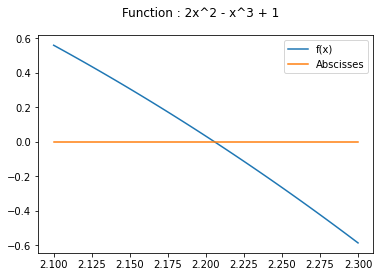

The approximation is = [[0, 10], [0.1, 2.2058122254864885], [0.2, 2.2055694775431514], [0.30000000000000004, 2.205569430400592], [0.4, 2.2055694304005904], [0.5, 2.2055694304005904], [0.6, 2.2055694304005904], [0.7, 2.2055694304005904], [0.7999999999999999, 2.2055694304005904], [0.8999999999999999, 2.2055694304005904], [0.9999999999999999, 2.2055694304005904], [1.0999999999999999, 2.2055694304005904], [1.2, 2.2055694304005904], [1.3, 2.2055694304005904], [1.4000000000000001, 2.2055694304005904], [1.5000000000000002, 2.2055694304005904], [1.6000000000000003, 2.2055694304005904], [1.7000000000000004, 2.2055694304005904], [1.8000000000000005, 2.2055694304005904], [1.9000000000000006, 2.2055694304005904], [2.0000000000000004, 2.2055694304005904], [2.1000000000000005, 2.2055694304005904], [2.2000000000000006, 2.2055694304005904], [2.3000000000000007, 2.2055694304005904], [2.400000000000001, 2.2055694304005904], [2.500000000000001, 2.2055694304005904], [2.600000000000001, 2.2055694304005904]

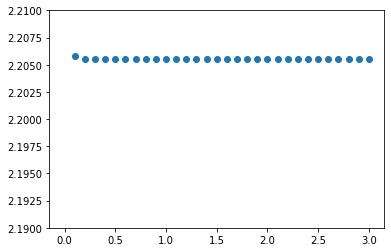

In [12]:
fig, ax = plt.subplots()
x_ = np.linspace(2.10, 2.30)
y = 2*x_**2 - x_**3 + 1
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
fig.suptitle('Function : 2x^2 - x^3 + 1')
plt.show()

vec = 2*x**2 - x**3 + 1
res = FirstModel(vec, 10)
print(res)
absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])

plt.ylim([2.19, 2.21])
plt.scatter(absi, coords)



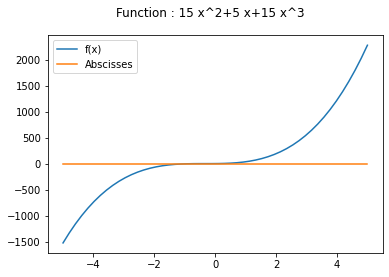

TypeError: FirstModel() takes 2 positional arguments but 3 were given

In [5]:
fig, ax = plt.subplots()
x_ = np.linspace(-5, 5)
y = 15*x_**(2) + 5*x_+ 15*x_**(3)
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
fig.suptitle('Function : 15 x^2+5 x+15 x^3')
plt.show()

vec = [15*x**(2) + 5*x + 15*x**(3)]
res = FirstModel(vec, 1, 3)
print(res)

In [ ]:
fig, ax = plt.subplots()
x_ = np.linspace(-5, 5)
y = np.cos(x_) - x_**3
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
fig.suptitle('Wikipedia example : cos(x) - x^3 = 0')
plt.show()

vec = sp.cos(x) - x**3
res = FirstModel(vec, 1, 3)
print(res)